# Configuration

In [1]:
from datetime import datetime
import os
import random

from colorama import Fore

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np

import matplotlib.animation as animation
import matplotlib.pyplot as plt

from IPython.display import HTML

In [2]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [3]:
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


In [4]:
OUTPUT_DIRECTORY = "output"
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

In [5]:
image_size = 32
batch_size = 128

learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999

# Loading data

In [6]:
DATASET_PATH = "../data/cifar10"


def get_cifar_loader_configuration(is_training: bool):
    return {
        "dataset": datasets.CIFAR10(
            DATASET_PATH,
            train=is_training,
            download=True,
            transform=transforms.Compose(
                [
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            ),
        ),
        "batch_size": batch_size,
        "shuffle": True,
    }

def show_example_from(loader: DataLoader):
    loader.batch_size
    features, labels = next(iter(loader))
    print(f"Feature batch shape: {features.size()}")
    print(f"Labels batch shape: {labels.size()}")
    image = features[0].squeeze()
    label = labels[0]
    image = image.permute(1, 2, 0)  # Change the shape to (32, 32, 3)
    image = (image + 1) / 2  # Adjust the values to [0, 1] range
    plt.imshow(image)
    plt.show()
    print(f"Label: {label}")

Files already downloaded and verified
Files already downloaded and verified
Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


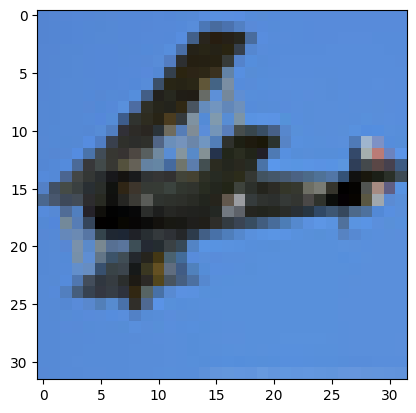

Label: 0
Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


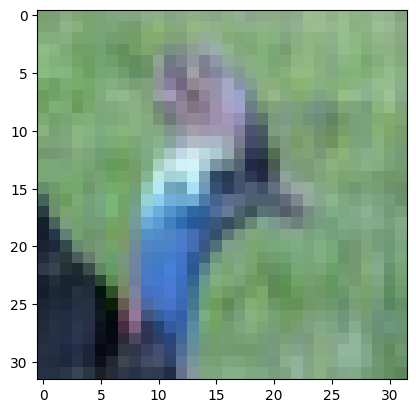

Label: 2


In [7]:
# Use the custom dataset in the data loader
train_dataloader = torch.utils.data.DataLoader(
    **get_cifar_loader_configuration(is_training=True)
)
# Use the custom dataset in the data loader
test_dataloader = torch.utils.data.DataLoader(
    **get_cifar_loader_configuration(is_training=False)
)

show_example_from(train_dataloader)
show_example_from(test_dataloader)

# Models

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)


# Create Discriminator and Generator instances on CUDA device
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# Initialize optimizer for Discriminator and Generator
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))

# Loss function
criterion = nn.BCELoss()

# Print info about the models
print(discriminator)
print(generator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 12

# Training loop

In [9]:
# Tracking progress
images = []
G_losses = []
D_losses = []

iterations_passed = 0
number_of_epochs = 15

model_save_interval = 1500
samples_save_interval = 500


def train_on_real_batch():
    discriminator.zero_grad()
    real_cpu = data_batch[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), 1, dtype=torch.float32, device=device)
    output = discriminator(real_cpu).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()
    return D_x, label, b_size, errD_real


def train_on_fake_batch():
    noise = torch.randn(b_size, 100, 1, 1, device=device)
    fake = generator(noise)
    label.fill_(0)
    output = discriminator(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    optimizerD.step()
    return noise, fake, D_G_z1, errD


def update_generator_network():
    generator.zero_grad()
    label.fill_(1)  # fake labels are real for generator cost
    output = discriminator(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()
    return D_G_z2, errG


def log_training():
    epoch_width = len(str(number_of_epochs))
    index_width = len(str(len(train_dataloader)))
    counters = f"{Fore.BLUE}[{epoch:>{epoch_width}}/{number_of_epochs}][{index:>{index_width}}/{len(train_dataloader)}]   "
    losses = f"{Fore.CYAN}Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}   "
    idk = f"{Fore.GREEN}D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}{Fore.RESET}"
    if index % 50 == 0:
        print("".join([counters, losses, idk]))


def save_loses():
    G_losses.append(errG.item())
    D_losses.append(errD.item())


def is_xth_or_last_epoch(x: int | None):
    return (iterations_passed % x == 0) or (
        (epoch == number_of_epochs - 1) and (index == len(train_dataloader) - 1)
    )


def save_sample_of_generator_progress(save_interval: int | None):
    if not save_interval or is_xth_or_last_epoch(x=save_interval):
        with torch.no_grad():
            fake = generator(noise).detach().cpu()
        images.append(vutils.make_grid(fake, padding=2, normalize=True))
        vutils.save_image(
            fake,
            f"{generated_images_directory}/fake_images_{iterations_passed if save_interval else f'{iterations_passed}_on_quit'}.png",
        )


def save_model(save_interval: int | None):
    if not save_interval or is_xth_or_last_epoch(x=save_interval):
        torch.save(
            generator.state_dict(),
            f"{checkpoints_directory}/generator_{iterations_passed if save_interval else 'on_quit'}.pth",
        )


def save_animation():
    image_plots = [
        [plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in images
    ]
    figure = plt.figure(figsize=(8, 8))
    plt.axis("off")
    training_animation = animation.ArtistAnimation(
        figure, image_plots, interval=1000, repeat_delay=1000, blit=True
    )
    HTML(training_animation.to_jshtml())
    training_animation.save(
        f"{today_directory}/animation.gif",
        writer="imagemagick",
        fps=4,
    )


def plot_losses():
    plt.figure()
    plt.plot(G_losses, label="Generator loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.legend()
    plt.savefig(f"{today_directory}/losses.png")
    plt.show()


def create_output_bucket():
    today = datetime.now()
    today_slug = f"{today.day:02}-{today.month:02}-{today.year:04}_{today.hour:02}:{today.minute:02}:{today.second:02}"
    today_directory = f"{OUTPUT_DIRECTORY}/{today_slug}"
    checkpoints_directory = f"{today_directory}/model_checkpoints"
    generated_images_directory = f"{today_directory}/generated_images"
    os.makedirs(today_directory, exist_ok=True)
    os.makedirs(checkpoints_directory, exist_ok=True)
    os.makedirs(generated_images_directory, exist_ok=True)
    return (
        today_directory,
        checkpoints_directory,
        generated_images_directory,
    )


try:
    (
        today_directory,
        checkpoints_directory,
        generated_images_directory,
    ) = create_output_bucket()
    print("Starting the training loop...")
    for epoch in range(number_of_epochs):
        for index, data_batch in enumerate(train_dataloader, 0):
            D_x, label, b_size, errD_real = train_on_real_batch()
            noise, fake, D_G_z1, errD = train_on_fake_batch()
            D_G_z2, errG = update_generator_network()
            log_training()
            save_loses()
            save_model(save_interval=model_save_interval)
            save_sample_of_generator_progress(save_interval=samples_save_interval)
            iterations_passed += 1
except KeyboardInterrupt:
    ...
finally:
    save_model(save_interval=None)
    save_sample_of_generator_progress(save_interval=None)
    plot_losses()
    save_animation()

Starting the training loop...
[ 0/15][  0/391]   Loss_D: 1.4748 Loss_G: 1.4585   D(x): 0.5690 D(G(z)): 0.5842/0.2421
[ 0/15][ 50/391]   Loss_D: 0.3279 Loss_G: 4.8452   D(x): 0.8350 D(G(z)): 0.1217/0.0093


# Visual samples

In [ ]:
# To use this, execute first cell, then Discriminator and Generator cells


def find_latest_checkpoint_directory():
    dates = os.listdir(f"{OUTPUT_DIRECTORY}")
    assert dates, "There are no saved generator states! Train a new one 🙏"
    dates.sort(
        key=lambda date: datetime.strptime(date, "%d-%m-%Y_%H:%M:%S"),
        reverse=True,
    )
    print(f"Picked output directory: {dates[0]}")
    return f"{OUTPUT_DIRECTORY}/{dates[0]}"


def find_latest_generator_path():
    checkpoints_directory = f"{latest_checkpoint_directory}/model_checkpoints/"
    generators = os.listdir(checkpoints_directory)
    generators.sort(key=lambda generator: generator, reverse=True)
    print(f"Picked generator: {generators[0]}")
    return f"{latest_checkpoint_directory}/model_checkpoints/{generators[0]}"


def load_latest_generator():
    generator = Generator().to(device)
    path = find_latest_generator_path()
    generator.load_state_dict(torch.load(path))
    return generator


def generate_fake_images():
    fixed_noise = torch.randn(64, 100, 1, 1, device=device)
    fake_images = newest_generator(fixed_noise)
    return fake_images


def plot_fake_images():
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(
                fake_images.to(device)[:64], padding=5, normalize=True
            ).cpu(),
            (1, 2, 0),
        )
    )


latest_checkpoint_directory = find_latest_checkpoint_directory()
newest_generator = load_latest_generator()
fake_images = generate_fake_images()
plot_fake_images()

: 